### Generate instance

In [8]:
import numpy as np
import os

class BiObjectiveDataGenerator:
    """
    生成帶有 stages 的雙目標調度問題實例
    - 每個 job 可以有不同數量的 stages (layers)
    - 每個 stage 可以有不同數量的 operations

    .jsp 文件格式:
    ---------
    10 10                          # num_jobs num_machines
    <operations for each job>      # 10 行
    -1                             # stage due dates placeholder
    599 762 921                    # job 0 的 stage due dates (3 stage layers)
    214 417                        # job 1 的 stage due dates (2 stage layers)
    ...                            # 其他 jobs
    -2                             # stage splits placeholder
    0 4 7 10                       # job 0: 3 stage layers (0-4, 4-7, 7-10)
    0 5 10                         # job 1: 2 stage layers (0-5, 5-10)
    ...

    """
    
    def __init__(self, seed=None):
        if seed:
            np.random.seed(seed)
    
    def generate_instance(self, 
                         num_jobs, 
                         num_machines,
                         min_stages=2,
                         max_stages=4,
                         tightness=1.3,
                         range_factor=0.6):
        """
        生成 stage-layer instance
        
        Args:
            num_jobs: 工件數量
            num_machines: 每個 job 的總 operations 數
            min_stages: 最小 stage 數
            max_stages: 最大 stage 數
            tightness: due date 緊度
            range_factor: due date 變異度
        """
        costs = np.random.randint(1, 100, (num_jobs, num_machines))
        machines = np.array([np.random.permutation(num_machines) 
                            for _ in range(num_jobs)])
        
        # 為每個 job 隨機決定 stage 數量，並生成對應的 stage 劃分
        stage_splits = []
        stage_due_dates = []
        
        for j in range(num_jobs):
            n_stages = np.random.randint(min_stages, max_stages + 1)
            
            # 生成這個job的stage劃分
            splits = self._generate_stage_splits_for_job(num_machines, n_stages)
            stage_splits.append(splits)
            
            # 為這個job的每個stage生成due date
            job_dds = []
            cumulative_time = 0
            
            for s in range(n_stages):
                start_op = splits[s]
                end_op = splits[s + 1]
                stage_time = costs[j, start_op:end_op].sum()
                cumulative_time += stage_time
                
                u = np.random.uniform(0, 1)
                dd = cumulative_time * (tightness - range_factor/2 + range_factor * u)
                job_dds.append(max(int(dd), cumulative_time))
            
            stage_due_dates.append(job_dds)
        
        return {
            'costs': costs, # 每個 operation 的加工時間
            'machines': machines,
            'stage_due_dates': stage_due_dates,  # 注意：這是list of lists，長度不同
            'stage_splits': stage_splits,
            'num_jobs': num_jobs,
            'num_machines': num_machines
        }
    
    """
    def _generate_stage_splits_for_job(self, num_machines, num_stages):
 
        if num_stages == 1:
            return [0, num_machines]
        
        # 使用 Dirichlet 生成比例
        alpha = np.ones(num_stages)  # 可以調整來控制均勻程度
        proportions = np.random.dirichlet(alpha)
        
        # 確保每個 stage 至少有1個 operation
        splits = [0]
        remaining = num_machines - num_stages
        
        for s in range(num_stages - 1):
            # 基於比例分配，但確保至少1個
            ops = max(1, int(proportions[s] * num_machines))
            ops = min(ops, remaining + 1)  # 確保後續 stage 有足夠的 ops
            splits.append(splits[-1] + ops)
            remaining -= ops
        
        splits.append(num_machines)
        
        return splits
    """
    
    def _generate_stage_splits_for_job(self, num_machines, num_stages):
        """
        保證：
        - 每個 stage 至少 1 個 operation
        - splits 嚴格遞增
        - 最後一個 split == num_machines
        """
        assert num_stages <= num_machines, \
            "num_stages cannot exceed number of operations"

        if num_stages == 1:
            return [0, num_machines]

        # Step 1: 每個 stage 先分 1 個 op
        base = np.ones(num_stages, dtype=int)

        # Step 2: 剩餘的 ops 隨機分配
        remaining = num_machines - num_stages
        if remaining > 0:
            extra = np.random.multinomial(remaining, np.ones(num_stages) / num_stages)
            stage_sizes = base + extra
        else:
            stage_sizes = base

        # Step 3: cumulative sum → splits
        splits = [0]
        for size in stage_sizes:
            splits.append(splits[-1] + size)

        return splits

    def save_instance(self, instance, filepath):
        """
        保存實例到文件
        """
        with open(filepath, 'w') as f:
            # 第1行：只有 jobs 和 machines
            f.write(f"{instance['num_jobs']} {instance['num_machines']}\n")
            
            # 第2到n+1行：每個 job 的 operations
            for j in range(instance['num_jobs']):
                line = []
                for m in range(instance['num_machines']):
                    line.extend([instance['machines'][j, m], 
                                instance['costs'][j, m]])
                f.write(" ".join(map(str, line)) + "\n")
            
            # stage_splits placeholder
            f.write("-1\n")
            for j in range(instance['num_jobs']):
                f.write(" ".join(map(str, instance['stage_splits'][j])) + "\n")
            
            # Stage due dates placeholder（每個 job 一行，長度可能不同）
            f.write("-2\n")
            for j in range(instance['num_jobs']):
                f.write(" ".join(map(str, instance['stage_due_dates'][j])) + "\n")
    
def read_stage_layer_instance(filepath):
    with open(filepath, 'r') as f:
        # 讀取基本信息
        line = f.readline().strip().split()
        num_jobs = int(line[0])
        num_machines = int(line[1])
        
        # 讀取operations
        costs = np.zeros((num_jobs, num_machines), dtype=int)
        machines = np.zeros((num_jobs, num_machines), dtype=int)
        
        for j in range(num_jobs):
            line = list(map(int, f.readline().strip().split()))
            for m in range(num_machines):
                machines[j, m] = line[2 * m]
                costs[j, m] = line[2 * m + 1]
        
        # 讀取makespan
        makespan_ub = int(f.readline().strip())
        
        # 讀取stage due dates（每個job的長度不同）
        stage_due_dates = []
        for j in range(num_jobs):
            dds = list(map(int, f.readline().strip().split()))
            stage_due_dates.append(dds)
        
        # 讀取stage splits
        stage_splits = None
        line = f.readline().strip()
        if line.startswith('-2'):
            stage_splits = []
            for j in range(num_jobs):
                splits = list(map(int, f.readline().strip().split()))
                stage_splits.append(splits)
    
    return {
        'num_jobs': num_jobs,
        'num_machines': num_machines,
        'costs': costs,
        'machines': machines,
        'makespan_ub': makespan_ub,
        'stage_due_dates': stage_due_dates,
        'stage_splits': stage_splits
    }

def generate_dataset_with_stages(output_dir, 
                                          num_instances=1000,
                                          num_jobs=10,
                                          num_machines=10,
                                          min_stages=2,
                                          max_stages=4):
    os.makedirs(output_dir, exist_ok=True)
    
    generator = BiObjectiveDataGenerator(seed=42)
    
    print(f"生成 {num_instances} 個帶有stage的實例...")
    print(f"  Jobs: {num_jobs}, Machines: {num_machines}")
    print(f"  Stages per job: {min_stages}-{max_stages}")
    
    for i in range(num_instances):
        instance = generator.generate_instance(
            num_jobs, num_machines, min_stages, max_stages
        )
        
        filename = f"nsga2_{num_jobs}x{num_machines}_{i:04d}.jsp"
        filepath = os.path.join(output_dir, filename)
        generator.save_instance(instance, filepath)
        
        if (i + 1) % 20 == 0:
            print(f"  已生成 {i + 1}/{num_instances}")
    
    print(f"完成！文件保存在 {output_dir}")


# 使用範例
if __name__ == "__main__":
    print("=" * 70)
    print("生成帶有 stage 的實例 - 每個 job 的 stage 數量和大小都可變")
    print("=" * 70)
    
    # 生成一個範例實例
    generator = BiObjectiveDataGenerator(seed=42)
    instance = generator.generate_instance(
        num_jobs=10,
        num_machines=10,
        min_stages=2,
        max_stages=4,
        tightness=1.3,
        range_factor=0.6
    )
    
    filepath = "example_nsga2.jsp"
    generator.save_instance(instance, filepath)
    print(f"\n已保存到: {filepath}")
    
    print("\n" + "=" * 70)
    print("讀取並驗證")
    print("=" * 70)
    loaded = read_stage_layer_instance(filepath)
    print(f"成功讀取: {loaded['num_jobs']} jobs, {loaded['num_machines']} machines")
    
    job_num_stages = [len(splits) - 1 for splits in loaded['stage_splits']]
    print(f"{filepath} 中每個 job 的 stage 數: {job_num_stages}")
    
    print("\n統計信息:")
    print(f"  總stage數: {sum(job_num_stages)}")
    print(f"  平均每個job的stage數: {np.mean(job_num_stages):.2f}")
    print(f"  Stage數分佈: {dict(zip(*np.unique(job_num_stages, return_counts=True)))}")
    
    print("\n" + "=" * 70)
    print("批量生成數據集")
    print("=" * 70)
    
    generate_dataset_with_stages(
        output_dir="./nsga2_dataset/10x10",
        num_instances=1000,
        num_jobs=10,
        num_machines=10,
        min_stages=2,
        max_stages=4
    )
    

生成帶有 stage 的實例 - 每個 job 的 stage 數量和大小都可變

已保存到: example_nsga2.jsp

讀取並驗證
成功讀取: 10 jobs, 10 machines
example_nsga2.jsp 中每個 job 的 stage 數: [2, 2, 1, 2, 2, 2, 3, 1, 3, 3]

統計信息:
  總stage數: 21
  平均每個job的stage數: 2.10
  Stage數分佈: {np.int64(1): np.int64(2), np.int64(2): np.int64(5), np.int64(3): np.int64(3)}

批量生成數據集
生成 1000 個帶有stage的實例...
  Jobs: 10, Machines: 10
  Stages per job: 2-4
  已生成 20/1000
  已生成 40/1000
  已生成 60/1000
  已生成 80/1000
  已生成 100/1000
  已生成 120/1000
  已生成 140/1000
  已生成 160/1000
  已生成 180/1000
  已生成 200/1000
  已生成 220/1000
  已生成 240/1000
  已生成 260/1000
  已生成 280/1000
  已生成 300/1000
  已生成 320/1000
  已生成 340/1000
  已生成 360/1000
  已生成 380/1000
  已生成 400/1000
  已生成 420/1000
  已生成 440/1000
  已生成 460/1000
  已生成 480/1000
  已生成 500/1000
  已生成 520/1000
  已生成 540/1000
  已生成 560/1000
  已生成 580/1000
  已生成 600/1000
  已生成 620/1000
  已生成 640/1000
  已生成 660/1000
  已生成 680/1000
  已生成 700/1000
  已生成 720/1000
  已生成 740/1000
  已生成 760/1000
  已生成 780/1000
  已生成 800/1000
  已生成 820/1000
  已生成 8

### Run nsga2 to solve instance

In [9]:
"""
NSGA-II for stage-layer JSP
Reads instance in the same format as example_stage_layer.jsp.
Objective 1: makespan
Objective 2: total number of tardy stage-outs
Output solution format:
    <makespan>, <tardy_count>
    machine 0 sequence...
    machine 1 sequence...
"""

import os
import time
import copy
import numpy as np

# ============================================================
# 讀取 stage-layer JSP instance
# ============================================================
def read_stage_layer_instance(path):
    with open(path, 'r', encoding='utf-8') as f:
        raw_lines = [ln.rstrip('\n') for ln in f]

    # 去除 "#" 之後的註解內容
    lines = []
    for ln in raw_lines:
        if "#" in ln:
            ln = ln.split("#", 1)[0]
        ln = ln.strip()
        if ln:
            lines.append(ln)

    # 第一行：num_jobs num_machines
    first = lines[0].split()
    num_jobs = int(first[0])
    num_machines = int(first[1])

    # job operations (machine, ptime) pairs
    job_ops = []
    idx = 1
    for j in range(num_jobs):
        parts = lines[idx].split()
        pairs = list(map(int, parts))
        ops = []
        for k in range(0, len(pairs), 2):
            m = pairs[k]
            p = pairs[k+1]
            ops.append((m, p))
        job_ops.append(ops)
        idx += 1

    # expect "-1"
    if lines[idx] == "-1":
        idx += 1

    # stage splits (每個 job 一行，長度 = stage 數 + 1)
    stage_splits = []
    for j in range(num_jobs):
        if idx >= len(lines):
            raise ValueError(f"Missing stage splits for job {j}")
        
        parts = list(map(int, lines[idx].split()))
        stage_splits.append(parts)
        idx += 1

    # expect "-2" before due dates
    if idx < len(lines) and lines[idx] == "-2":
        idx += 1

    # due dates per job per stage (長度可能不同)
    due_dates = []
    for j in range(num_jobs):
        if idx >= len(lines):
            raise ValueError(f"Missing due dates for job {j}")
        
        parts = list(map(int, lines[idx].split()))
        # 驗證：due_dates 數量應該 = len(splits) - 1
        num_stages = len(stage_splits[j]) - 1
        if len(parts) != num_stages:
            raise ValueError(f"Due date count mismatch for job {j}: "
                           f"expected {num_stages} (from stage_splits), got {len(parts)}")
        
        due_dates.append(parts)
        idx += 1

    num_stages_per_job = [len(splits) - 1 for splits in stage_splits]

    return {
        "num_jobs": num_jobs,
        "num_machines": num_machines,
        "job_ops": job_ops,
        "num_stages_per_job": num_stages_per_job,
        "due_dates": due_dates,
        "stage_splits": stage_splits
    }

# ============================================================
# NSGA-II functions
# ============================================================

def non_dominated_sorting(pop_size, chroms_obj):
    s, n = {}, {}
    front = {0: []}
    total = len(chroms_obj)

    for p in range(total):
        s[p] = []
        n[p] = 0
        for q in range(total):
            # minimize both obj
            if ((chroms_obj[p][0] < chroms_obj[q][0] and chroms_obj[p][1] < chroms_obj[q][1]) or
                (chroms_obj[p][0] <= chroms_obj[q][0] and chroms_obj[p][1] < chroms_obj[q][1]) or
                (chroms_obj[p][0] < chroms_obj[q][0] and chroms_obj[p][1] <= chroms_obj[q][1])):
                s[p].append(q)
            elif ((chroms_obj[p][0] > chroms_obj[q][0] and chroms_obj[p][1] > chroms_obj[q][1]) or
                  (chroms_obj[p][0] >= chroms_obj[q][0] and chroms_obj[p][1] > chroms_obj[q][1]) or
                  (chroms_obj[p][0] > chroms_obj[q][0] and chroms_obj[p][1] >= chroms_obj[q][1])):
                n[p] += 1

        if n[p] == 0:
            front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in s[p]:
                n[q] -= 1
                if n[q] == 0:
                    Q.append(q)
        i += 1
        front[i] = Q

    del front[len(front)-1]
    return front

def calculate_crowding_distance(front, chroms_obj):
    dist = {k: 0 for k in front}
    for obj_idx in range(2):
        obj = {k: chroms_obj[k][obj_idx] for k in front}
        sorted_keys = sorted(obj, key=obj.get)
        dist[sorted_keys[0]] = dist[sorted_keys[-1]] = 1e12

        if obj[sorted_keys[0]] == obj[sorted_keys[-1]]:
            continue

        for i in range(1, len(sorted_keys)-1):
            dist[sorted_keys[i]] += (
                obj[sorted_keys[i+1]] - obj[sorted_keys[i-1]]
            ) / (obj[sorted_keys[-1]] - obj[sorted_keys[0]])

    return dist

def selection(pop_size, front, chroms_obj, total_chroms):
    new_pop_ids = []
    N = 0

    for i in range(len(front)):
        if N + len(front[i]) > pop_size:
            dist = calculate_crowding_distance(front[i], chroms_obj)
            sorted_ids = sorted(dist, key=dist.get, reverse=True)
            for sid in sorted_ids:
                if len(new_pop_ids) == pop_size:
                    break
                new_pop_ids.append(sid)
            break
        else:
            new_pop_ids.extend(front[i])
            N += len(front[i])

    new_pop = [total_chroms[i] for i in new_pop_ids]
    return new_pop, new_pop_ids

# ============================================================
# Fitness evaluation
# ============================================================
def evaluate_chromosome(chrom, inst):
    num_jobs = inst["num_jobs"]
    num_machines = inst["num_machines"]
    job_ops = inst["job_ops"]
    stage_splits = inst["stage_splits"]
    due_dates = inst["due_dates"]

    ops_per_job = len(job_ops[0])  # e.g. 10 ops per job

    job_op_finish = [ [0]*len(job_ops[j]) for j in range(num_jobs) ]
    machine_available = [0]*num_machines
    key_cnt = [0]*num_jobs

    # 改成紀錄 operation ID 而不是 job ID
    machine_seq = [[] for _ in range(num_machines)]

    for job in chrom:
        op = key_cnt[job]
        if op >= len(job_ops[job]):
            key_cnt[job] += 1
            continue

        m, p = job_ops[job][op]
        prev = job_op_finish[job][op-1] if op > 0 else 0
        start = max(machine_available[m], prev)
        finish = start + p

        job_op_finish[job][op] = finish
        machine_available[m] = finish

        # ⭐ global operation ID = job * ops_per_job + op
        global_op_id = job * ops_per_job + op
        machine_seq[m].append(global_op_id)

        key_cnt[job] += 1

    makespan = max(machine_available)

    # 計算 tardy-stageouts
    tardy_count = 0
    for j in range(num_jobs):
        splits = stage_splits[j]
        for s in range(len(splits)-1):
            st, ed = splits[s], splits[s+1]
            if st < ed:
                stage_finish = max(job_op_finish[j][k] for k in range(st, ed))
            else:
                stage_finish = 0
            if stage_finish > due_dates[j][s]:
                tardy_count += 1

    return (makespan, tardy_count), machine_seq

# ============================================================
# Main NSGA-II
# ============================================================
def run_nsga2(instance_path, population_size=30, generations=200,
              crossover_rate=0.8, mutation_rate=0.35, mutation_sel_rate=0.4):

    inst = read_stage_layer_instance(instance_path)
    num_jobs = inst["num_jobs"]
    ops_per_job = len(inst["job_ops"][0])
    L = num_jobs * ops_per_job

    # 初始族群
    pop = []
    for _ in range(population_size):
        perm = np.random.permutation(L)
        chrom = [perm[k] % num_jobs for k in range(L)]
        pop.append(chrom)

    num_mut_ops = max(1, int(L * mutation_sel_rate))
    best_list = []
    best_obj = []

    for g in range(generations):
        # 交配
        offspring = []
        order = np.random.permutation(population_size)
        for i in range(0, population_size, 2):
            p1 = pop[order[i]][:]
            p2 = pop[order[i+1]][:]
            if np.random.rand() < crossover_rate:
                c1, c2 = p1[:], p2[:]
                cut = np.random.choice(L, 2, replace=False)
                cut.sort()
                c1[cut[0]:cut[1]] = p2[cut[0]:cut[1]]
                c2[cut[0]:cut[1]] = p1[cut[0]:cut[1]]
            else:
                c1, c2 = p1, p2
            offspring.append(c1)
            offspring.append(c2)

        # repair 每個 job 出現次數 = ops_per_job
        for ch in offspring:
            counts = {j: ch.count(j) for j in range(num_jobs)}
            more = [j for j in counts if counts[j] > ops_per_job]
            less = [j for j in counts if counts[j] < ops_per_job]

            for j in more:
                while counts[j] > ops_per_job:
                    for k in less:
                        if counts[k] < ops_per_job:
                            pos = ch.index(j)
                            ch[pos] = k
                            counts[j] -= 1
                            counts[k] += 1
                            if counts[j] == ops_per_job:
                                break

        # 突變
        for ch in offspring:
            if np.random.rand() < mutation_rate:
                pos = np.random.choice(L, num_mut_ops, replace=False)
                tmp = ch[pos[0]]
                for t in range(num_mut_ops-1):
                    ch[pos[t]] = ch[pos[t+1]]
                ch[pos[-1]] = tmp

        # 合併
        total = pop + offspring
        chroms_obj = {}
        for i, ch in enumerate(total):
            obj, _ = evaluate_chromosome(ch, inst)
            chroms_obj[i] = [obj[0], obj[1]]

        # 排序
        front = non_dominated_sorting(population_size, chroms_obj)
        pop, new_id = selection(population_size, front, chroms_obj, total)

        # 更新最佳紀錄
        new_obj = [chroms_obj[i] for i in new_id]
        if g == 0:
            best_list = copy.deepcopy(pop)
            best_obj = copy.deepcopy(new_obj)
        else:
            total_list = pop + best_list
            total_obj = new_obj + best_obj
            f2 = non_dominated_sorting(population_size, total_obj)
            best_list, best_id = selection(population_size, f2, total_obj, total_list)
            best_obj = [total_obj[i] for i in best_id]

    final_chrom = best_list[0]
    final_obj, final_seq = evaluate_chromosome(final_chrom, inst)
    return final_chrom, final_obj, final_seq

# ============================================================
# 生成訓練數據（合併問題實例和解決方案）
# ============================================================
def generate_training_data(instance_path, solution_obj, solution_seq, output_path):
    """
    合併問題實例和 NSGA-II 解決方案成訓練數據
    
    訓練數據格式:
        10 10  # num_jobs num_machines
        [問題實例部分]
        [空行]
        [解決方案部分]
        makespan, tardy_count
        machine 0 sequence...
        machine 1 sequence...
    """
    inst = read_stage_layer_instance(instance_path)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        # ===== 第一部分：問題實例 =====
        f.write(f"{inst['num_jobs']} {inst['num_machines']}\n")
        
        # job operations (machine, ptime) pairs
        for j in range(inst['num_jobs']):
            ops = inst['job_ops'][j]
            line = []
            for m, p in ops:
                line.extend([str(m), str(p)])
            f.write(" ".join(line) + "\n")
        
        # "-1" 分隔符
        f.write("-1\n")
        
        # stage splits
        for j in range(inst['num_jobs']):
            f.write(" ".join(map(str, inst['stage_splits'][j])) + "\n")
        
        # "-2" 分隔符
        f.write("-2\n")
        
        # due dates
        for j in range(inst['num_jobs']):
            f.write(" ".join(map(str, inst['due_dates'][j])) + "\n")
        
        # ===== 第二部分：解決方案 =====
        f.write("\n")
        f.write(f"{solution_obj[0]} {solution_obj[1]}\n")
        
        # machine sequences
        for m in range(len(solution_seq)):
            f.write(" ".join(str(job_id) for job_id in solution_seq[m]) + "\n")

# ============================================================
# 批量生成訓練數據
# ============================================================
def batch_generate_training_data(dataset_dir, output_dir="training_data", 
                                 population_size=50, generations=200,
                                 crossover_rate=0.8, mutation_rate=0.3, 
                                 mutation_sel_rate=0.3):  # 添加這些參數
    """
    批量為數據集中的所有題目生成訓練數據
    
    Args:
        dataset_dir: 題目數據集目錄
        output_dir: 輸出訓練數據的目錄
        population_size: NSGA-II 族群大小
        generations: NSGA-II 代數
        crossover_rate: 交叉率
        mutation_rate: 變異率
        mutation_sel_rate: 變異選擇率
    """
    import glob
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 獲取所有 .jsp 檔案
    problem_files = sorted(glob.glob(os.path.join(dataset_dir, "*.jsp")))
    
    print(f"找到 {len(problem_files)} 個題目")
    
    for idx, problem_file in enumerate(problem_files):
        base_name = os.path.splitext(os.path.basename(problem_file))[0]
        
        print(f"\n[{idx+1}/{len(problem_files)}] 處理: {base_name}")
        
        try:
            # 執行 NSGA-II - 傳遞所有參數
            chrom, obj, seq = run_nsga2(
                problem_file, 
                population_size=population_size,
                generations=generations,
                crossover_rate=crossover_rate,      # 添加
                mutation_rate=mutation_rate,        # 添加
                mutation_sel_rate=mutation_sel_rate # 添加
            )
            
            print(f"  Best makespan = {obj[0]}, tardy_count = {obj[1]}")
            
            # 生成訓練數據（副檔名為 .jsp）
            output_file = os.path.join(output_dir, f"{base_name}_traindata.jsp")
            generate_training_data(problem_file, obj, seq, output_file)
            print(f"  ✓ 訓練數據已生成: {output_file}")
            
        except Exception as e:
            print(f"  ✗ 錯誤: {e}")
            continue
    
    print(f"\n所有訓練數據已生成至: {output_dir}")
# ============================================================
# 主程式執行 + 輸出
# ============================================================
if __name__ == "__main__":
    # ===== 單個檔案執行 =====
    # instance = "example_flexible_stage.jsp"
    # chrom, obj, seq = run_nsga2(instance, population_size=50, generations=200)
    # outname = "example_flexible_stage_NSGA2_solution.txt"
    # with open(outname, "w", encoding="utf-8") as f:
    #     f.write(f"{obj[0]}, {obj[1]}    # makespan, total_tardy_stageouts\n")
    #     for m in range(len(seq)):
    #         f.write(" ".join(str(j) for j in seq[m]) + "\n")
    # print("Done. Result saved to:", outname)
    # generate_training_data(instance, obj, seq, outname.replace("_NSGA2_solution.txt", "_traindata.jsp"))
    
    # ===== 批量生成訓練數據 =====
    batch_generate_training_data(
        "nsga2_dataset/10x10",
        output_dir="training_data/10x10",
        population_size=100,      # 增加族群多樣性
        generations=300,          # 增加搜索深度
        crossover_rate=0.8,       # 保持原值
        mutation_rate=0.3,        # 略微降低（避免過度破壞）
        mutation_sel_rate=0.3     # 降低變異範圍（原0.4）
    ) 

找到 1000 個題目

[1/1000] 處理: nsga2_10x10_0000
  Best makespan = 1173, tardy_count = 21
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0000_traindata.jsp

[2/1000] 處理: nsga2_10x10_0001
  Best makespan = 940, tardy_count = 18
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0001_traindata.jsp

[3/1000] 處理: nsga2_10x10_0002
  Best makespan = 937, tardy_count = 22
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0002_traindata.jsp

[4/1000] 處理: nsga2_10x10_0003
  Best makespan = 1000, tardy_count = 25
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0003_traindata.jsp

[5/1000] 處理: nsga2_10x10_0004
  Best makespan = 878, tardy_count = 22
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0004_traindata.jsp

[6/1000] 處理: nsga2_10x10_0005
  Best makespan = 1018, tardy_count = 25
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0005_traindata.jsp

[7/1000] 處理: nsga2_10x10_0006
  Best makespan = 990, tardy_count = 20
  ✓ 訓練數據已生成: training_data/10x10\nsga2_10x10_0006_traindata.jsp

[8/1000] 處理: nsga2_10x10_0007
  Best ma

### Draw gantt

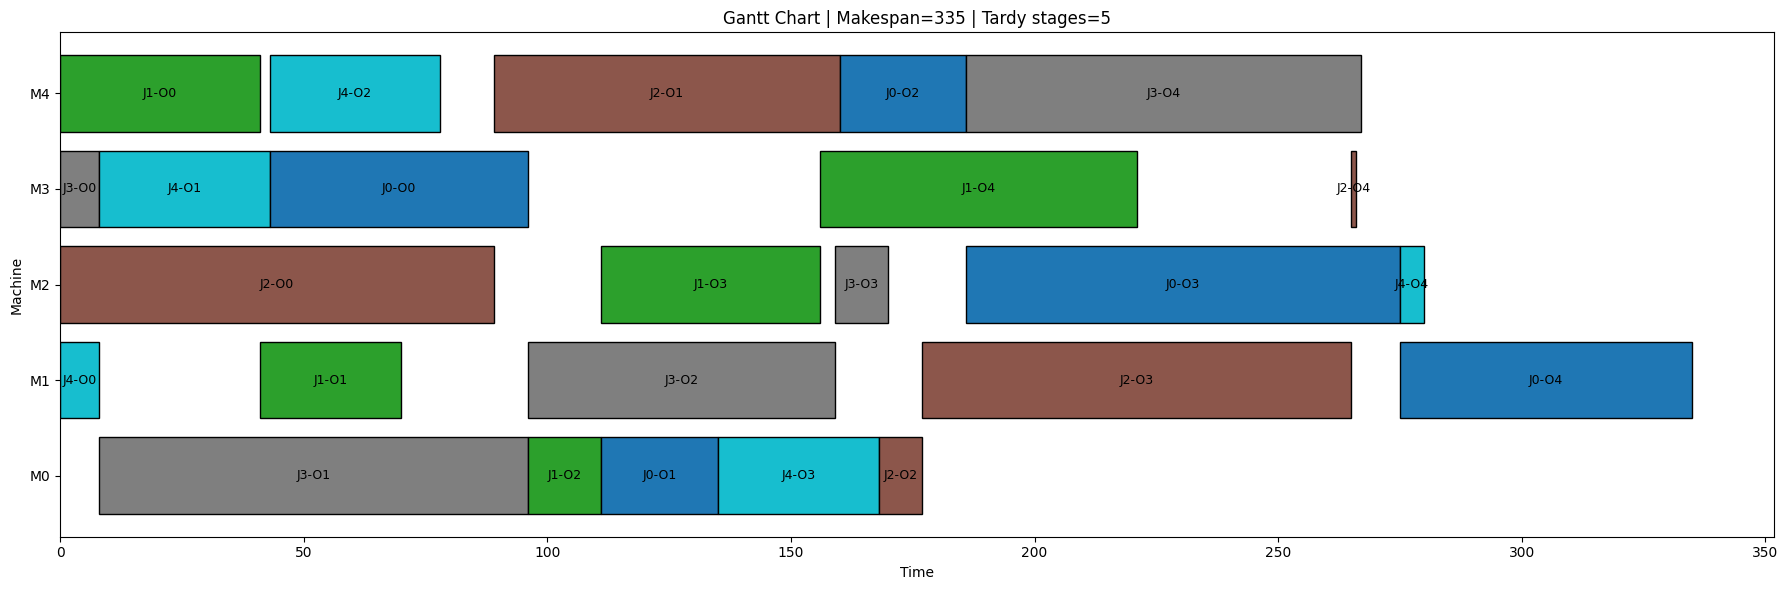

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 讀檔（支援你貼的格式）
# --------------------------------------------------
def read_instance(path):
    def next_non_empty(f):
        while True:
            line = f.readline()
            if not line:
                return None
            line = line.strip()
            if line:
                return line

    with open(path) as f:
        # jobs, machines
        line = next_non_empty(f)
        J, M = map(int, line.split())

        machines = np.zeros((J, M), dtype=int)
        costs = np.zeros((J, M), dtype=int)

        # operations
        for j in range(J):
            row = list(map(int, next_non_empty(f).split()))
            for o in range(M):
                machines[j, o] = row[2*o]
                costs[j, o] = row[2*o + 1]

        # -1
        assert next_non_empty(f) == "-1"

        stage_splits = []
        for _ in range(J):
            stage_splits.append(list(map(int, next_non_empty(f).split())))

        # -2
        assert next_non_empty(f) == "-2"

        stage_dd = []
        for _ in range(J):
            stage_dd.append(list(map(int, next_non_empty(f).split())))

        # makespan, tardy
        line = next_non_empty(f)
        makespan, tardy = map(int, line.split())

        # machine sequences
        machine_seq = []
        for _ in range(M):
            machine_seq.append(list(map(int, next_non_empty(f).split())))

    return J, M, machines, costs, stage_splits, stage_dd, machine_seq


# --------------------------------------------------
# 正確的 schedule builder（重點）
# --------------------------------------------------
def build_schedule(J, M, machines, costs, machine_seq):
    # gid → (job, op)
    gid_to_jo = {}
    for j in range(J):
        for o in range(M):
            gid_to_jo[j*M + o] = (j, o)

    # 追蹤每個 Job 的完工時間 (一維陣列即可)
    job_ready_time = [0] * J
    # 追蹤每台機器的完工時間
    mach_ready_time = [0] * M
    
    # 用來存放最終結果
    schedule = []
    # job_finish 矩陣用於計算 Tardy
    job_finish = [[0] * M for _ in range(J)]

    # 準備一個指針，紀錄每台機器目前處理到第幾個任務
    # 因為 machine_seq 是固定順序，我們只需按順序排入
    # 修正重點：建立一個待處理清單，只要該工序的前序好了，就嘗試排入
    queue = []
    for m in range(M):
        for gid in machine_seq[m]:
            j, o = gid_to_jo[gid]
            queue.append({'gid': gid, 'm': m, 'j': j, 'o': o})

    # 模擬排程
    # 這裡我們必須處理 Precedence (Job 內工序順序)
    # 我們重複檢查 queue，直到所有任務都排進去
    finished_count = 0
    ops_done = [[False] * M for _ in range(J)]
    processed_gid = set()

    while finished_count < J * M:
        progress = False
        for m in range(M):
            # 找到這台機器序列中下一個「尚未處理」的任務
            target_gid = None
            for gid in machine_seq[m]:
                if gid not in processed_gid:
                    target_gid = gid
                    break
            
            if target_gid is None:
                continue
                
            j, o = gid_to_jo[target_gid]
            
            # 檢查 Job 的前序工序是否完成
            if o > 0 and not ops_done[j][o-1]:
                continue # 前序沒好，這台機器現在只能等
            
            # 執行排程：開始時間 = max(機器空閒, Job前序完工)
            start = max(mach_ready_time[m], job_ready_time[j])
            duration = costs[j, o]
            end = start + duration
            
            # 更新狀態
            schedule.append((m, start, end, j, o))
            mach_ready_time[m] = end
            job_ready_time[j] = end
            job_finish[j][o] = end
            ops_done[j][o] = True
            processed_gid.add(target_gid)
            finished_count += 1
            progress = True
            
        if not progress:
            # 如果一輪下來都沒進度，代表 machine_seq 的順序與 Job 順序產生了 Deadlock (死結)
            # 這在 NSGA-II 的合法染色體下不應該發生
            raise RuntimeError("❌ 無法解碼：請檢查 machine_seq 是否違反了 Job 內部的工序順序。")

    return schedule, job_finish
# --------------------------------------------------
# 甘特圖
# --------------------------------------------------
def plot_gantt(path):
    J, M, machines, costs, splits, dds, machine_seq = read_instance(path)
    schedule, job_finish = build_schedule(J, M, machines, costs, machine_seq)

    colors = plt.cm.tab10(np.linspace(0, 1, J))
    fig, ax = plt.subplots(figsize=(18, 6))

    for m, s, e, j, o in schedule:
        ax.barh(m, e-s, left=s, color=colors[j], edgecolor="black")
        ax.text((s+e)/2, m, f"J{j}-O{o}", ha="center", va="center", fontsize=9)

    # stage tardy
    tardy = 0
    for j in range(J):
        for s in range(len(splits[j]) - 1):
            st, ed = splits[j][s], splits[j][s+1]
            if st == ed:
                continue
            finish = max(job_finish[j][st:ed])
            dd = dds[j][s]
            #ax.axvline(dd, color="red", linestyle="--", alpha=0.6)
            if finish > dd:
                #ax.axvspan(dd, finish, color="red", alpha=0.15)
                tardy += 1

    makespan = max(e for _, _, e, _, _ in schedule)

    ax.set_title(f"Gantt Chart | Makespan={makespan} | Tardy stages={tardy}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_yticks(range(M))
    ax.set_yticklabels([f"M{m}" for m in range(M)])
    plt.tight_layout()
    plt.show()

plot_gantt("training_data/5x5/nsga2_5x5_0001_traindata.jsp")

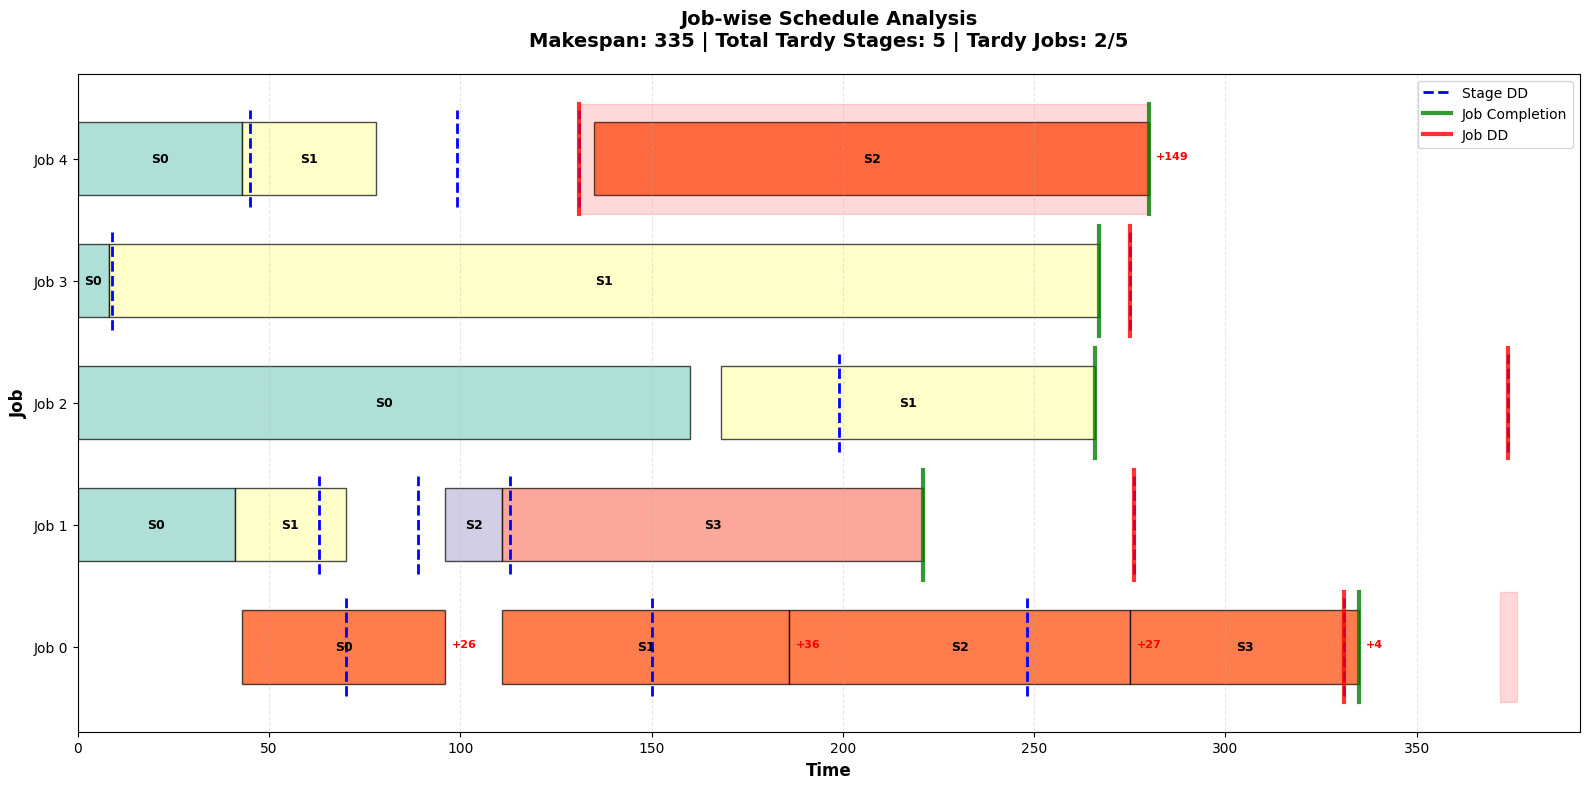

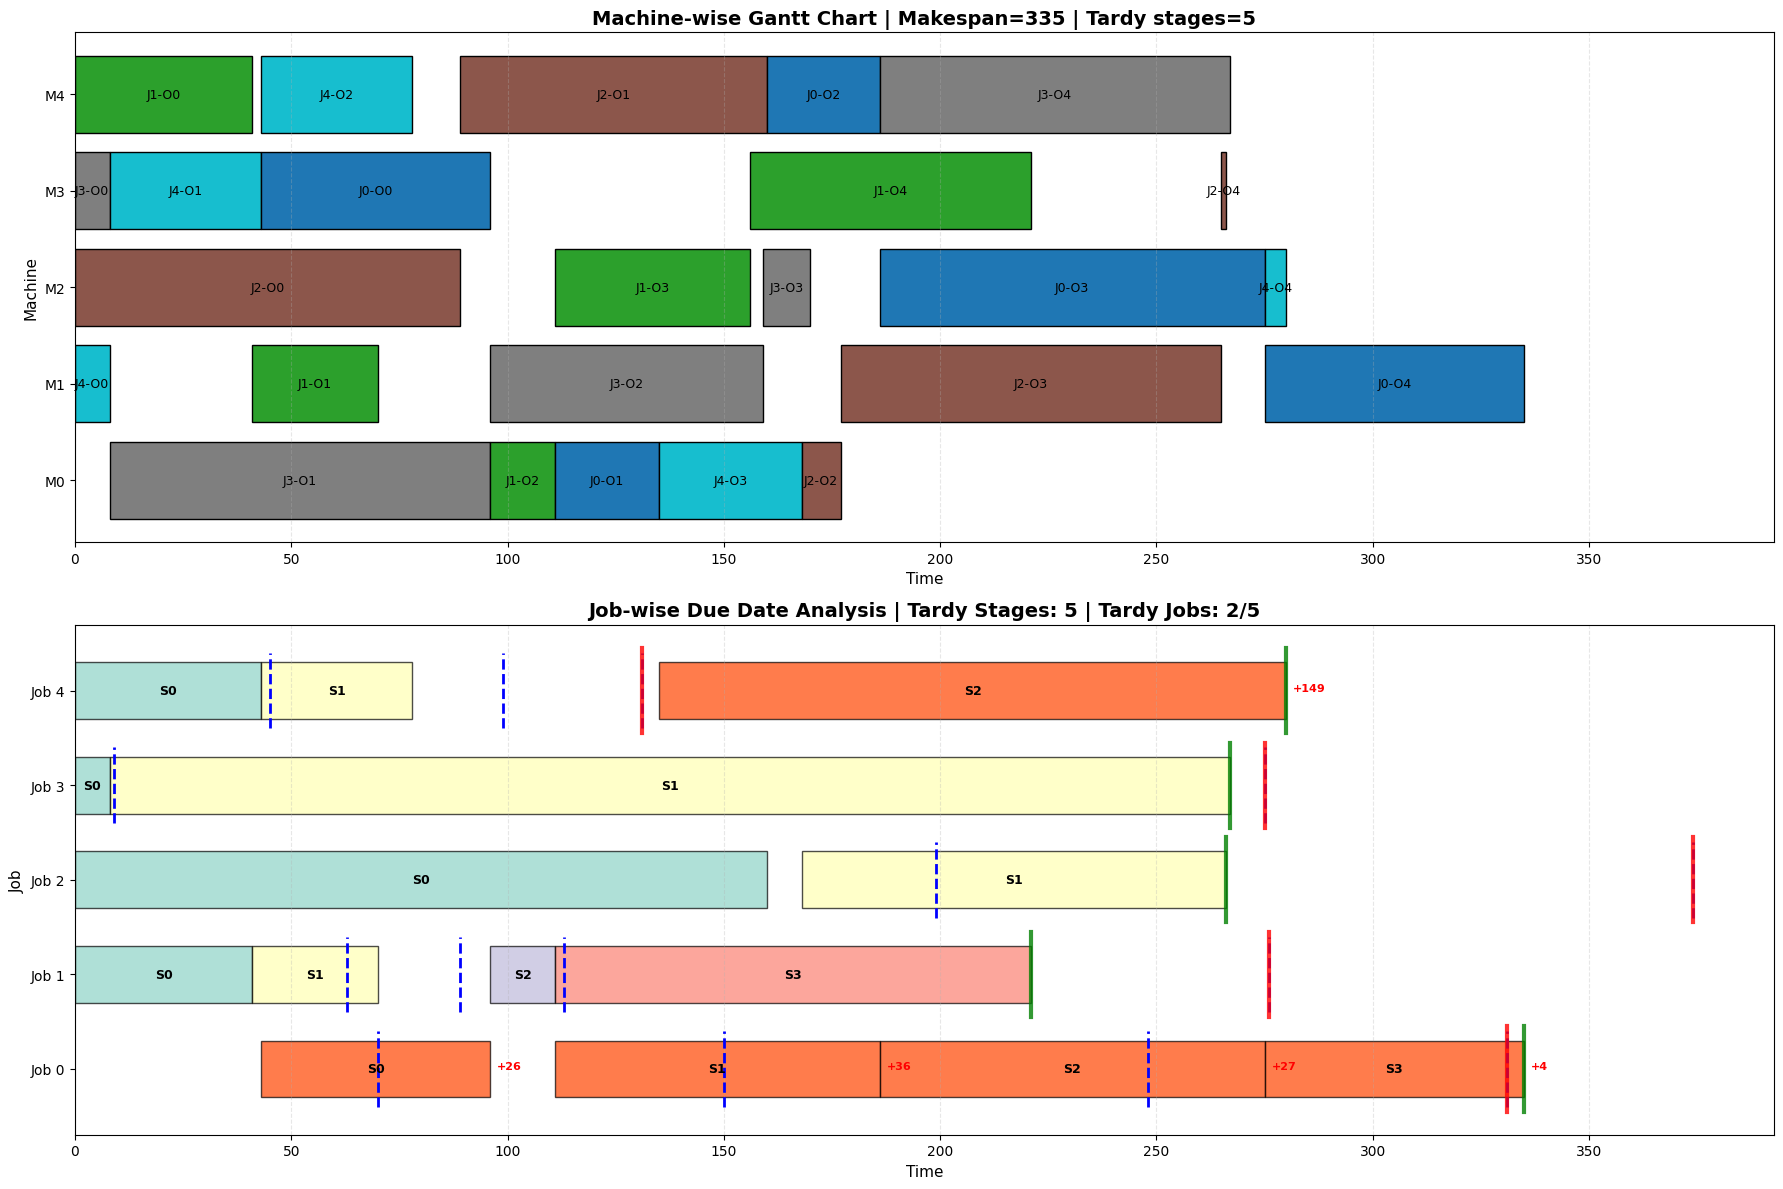

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 讀檔（支援你貼的格式）
# --------------------------------------------------
def read_instance(path):
    def next_non_empty(f):
        while True:
            line = f.readline()
            if not line:
                return None
            line = line.strip()
            if line:
                return line

    with open(path) as f:
        # jobs, machines
        line = next_non_empty(f)
        J, M = map(int, line.split())

        machines = np.zeros((J, M), dtype=int)
        costs = np.zeros((J, M), dtype=int)

        # operations
        for j in range(J):
            row = list(map(int, next_non_empty(f).split()))
            for o in range(M):
                machines[j, o] = row[2*o]
                costs[j, o] = row[2*o + 1]

        # -1
        assert next_non_empty(f) == "-1"

        stage_splits = []
        for _ in range(J):
            stage_splits.append(list(map(int, next_non_empty(f).split())))

        # -2
        assert next_non_empty(f) == "-2"

        stage_dd = []
        for _ in range(J):
            stage_dd.append(list(map(int, next_non_empty(f).split())))

        # makespan, tardy
        line = next_non_empty(f)
        makespan, tardy = map(int, line.split())

        # machine sequences
        machine_seq = []
        for _ in range(M):
            machine_seq.append(list(map(int, next_non_empty(f).split())))

    return J, M, machines, costs, stage_splits, stage_dd, machine_seq


# --------------------------------------------------
# 正確的 schedule builder
# --------------------------------------------------
def build_schedule(J, M, machines, costs, machine_seq):
    # gid → (job, op)
    gid_to_jo = {}
    for j in range(J):
        for o in range(M):
            gid_to_jo[j*M + o] = (j, o)

    # 追蹤每個 Job 的完工時間 (一維陣列即可)
    job_ready_time = [0] * J
    # 追蹤每台機器的完工時間
    mach_ready_time = [0] * M
    
    # 用來存放最終結果
    schedule = []
    # job_finish 矩陣用於計算 Tardy
    job_finish = [[0] * M for _ in range(J)]

    # 準備一個指針，紀錄每台機器目前處理到第幾個任務
    # 因為 machine_seq 是固定順序，我們只需按順序排入
    # 修正重點：建立一個待處理清單，只要該工序的前序好了，就嘗試排入
    queue = []
    for m in range(M):
        for gid in machine_seq[m]:
            j, o = gid_to_jo[gid]
            queue.append({'gid': gid, 'm': m, 'j': j, 'o': o})

    # 模擬排程
    # 這裡我們必須處理 Precedence (Job 內工序順序)
    # 我們重複檢查 queue，直到所有任務都排進去
    finished_count = 0
    ops_done = [[False] * M for _ in range(J)]
    processed_gid = set()

    while finished_count < J * M:
        progress = False
        for m in range(M):
            # 找到這台機器序列中下一個「尚未處理」的任務
            target_gid = None
            for gid in machine_seq[m]:
                if gid not in processed_gid:
                    target_gid = gid
                    break
            
            if target_gid is None:
                continue
                
            j, o = gid_to_jo[target_gid]
            
            # 檢查 Job 的前序工序是否完成
            if o > 0 and not ops_done[j][o-1]:
                continue # 前序沒好，這台機器現在只能等
            
            # 執行排程：開始時間 = max(機器空閒, Job前序完工)
            start = max(mach_ready_time[m], job_ready_time[j])
            duration = costs[j, o]
            end = start + duration
            
            # 更新狀態
            schedule.append((m, start, end, j, o))
            mach_ready_time[m] = end
            job_ready_time[j] = end
            job_finish[j][o] = end
            ops_done[j][o] = True
            processed_gid.add(target_gid)
            finished_count += 1
            progress = True
            
        if not progress:
            # 如果一輪下來都沒進度，代表 machine_seq 的順序與 Job 順序產生了 Deadlock (死結)
            # 這在 NSGA-II 的合法染色體下不應該發生
            raise RuntimeError("❌ 無法解碼：請檢查 machine_seq 是否違反了 Job 內部的工序順序。")

    return schedule, job_finish

# --------------------------------------------------
# Job視角的Due Date與Tardy視覺化
# --------------------------------------------------
def plot_job_due_dates(path):
    J, M, machines, costs, splits, dds, machine_seq = read_instance(path)
    schedule, job_finish = build_schedule(J, M, machines, costs, machine_seq)

    fig, ax = plt.subplots(figsize=(16, max(8, J * 0.8)))
    
    colors = plt.cm.Set3(np.linspace(0, 1, 12))
    
    total_tardy_stages = 0
    tardy_jobs = 0
    
    for j in range(J):
        # 計算每個stage的完成時間和tardy情況
        job_has_tardy = False
        
        for s in range(len(splits[j]) - 1):
            st_op, ed_op = splits[j][s], splits[j][s+1]
            
            if st_op == ed_op:
                continue
            
            # Stage的完成時間 = 該stage內所有operations的最大完成時間
            stage_finish = max(job_finish[j][st_op:ed_op])
            stage_due = dds[j][s]
            
            # 畫出stage的執行區間
            stage_start = min(
                start for m, start, end, jj, o in schedule 
                if jj == j and st_op <= o < ed_op
            )
            
            # 判斷是否tardy
            is_tardy = stage_finish > stage_due
            if is_tardy:
                total_tardy_stages += 1
                job_has_tardy = True
            
            # 畫stage執行時間條
            color = 'orangered' if is_tardy else colors[s % len(colors)]
            ax.barh(j, stage_finish - stage_start, left=stage_start, 
                   height=0.6, color=color, alpha=0.7, edgecolor='black', linewidth=1)
            
            # 標示stage編號
            ax.text((stage_start + stage_finish) / 2, j, f'S{s}', 
                   ha='center', va='center', fontsize=9, fontweight='bold')
            
            # 畫stage due date線
            ax.plot([stage_due, stage_due], [j - 0.4, j + 0.4], 
                   'b--', linewidth=2, label='Stage DD' if j == 0 and s == 0 else '')
            
            # 如果tardy，標示延遲量
            if is_tardy:
                delay = stage_finish - stage_due
                ax.annotate(f'+{delay}', xy=(stage_finish, j), 
                           xytext=(5, 0), textcoords='offset points',
                           fontsize=8, color='red', fontweight='bold')
        
        if job_has_tardy:
            tardy_jobs += 1
        
        # 計算整個job的完成時間
        job_completion = max(job_finish[j])
        
        # 畫job完成時間的豎線
        ax.plot([job_completion, job_completion], [j - 0.45, j + 0.45], 
               'g-', linewidth=3, alpha=0.8, 
               label='Job Completion' if j == 0 else '')
        
        # Job due date (取最後一個stage的due date)
        job_due = dds[j][-1] if dds[j] else 0
        if job_due > 0:
            ax.plot([job_due, job_due], [j - 0.45, j + 0.45], 
                   'r-', linewidth=3, alpha=0.8,
                   label='Job DD' if j == 0 else '')
            
            # 如果job tardy，畫延遲區域
            if job_completion > job_due:
                ax.axhspan(j - 0.45, j + 0.45, xmin=job_due/ax.get_xlim()[1], 
                          xmax=job_completion/ax.get_xlim()[1], 
                          color='red', alpha=0.15)
    
    # 設定圖表屬性
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Job', fontsize=12, fontweight='bold')
    ax.set_yticks(range(J))
    ax.set_yticklabels([f'Job {j}' for j in range(J)])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # 標題包含統計資訊
    makespan = max(e for _, _, e, _, _ in schedule)
    ax.set_title(
        f'Job-wise Schedule Analysis\n'
        f'Makespan: {makespan} | Total Tardy Stages: {total_tardy_stages} | Tardy Jobs: {tardy_jobs}/{J}',
        fontsize=14, fontweight='bold', pad=20
    )
    
    # 圖例
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()


# --------------------------------------------------
# 主程式：畫兩張圖
# --------------------------------------------------
def plot_both_views(path):
    """同時畫Machine視角和Job視角的圖"""
    J, M, machines, costs, splits, dds, machine_seq = read_instance(path)
    schedule, job_finish = build_schedule(J, M, machines, costs, machine_seq)
    
    fig = plt.figure(figsize=(18, 12))
    
    # ============ 上半部：Machine Gantt Chart ============
    ax1 = plt.subplot(2, 1, 1)
    colors = plt.cm.tab10(np.linspace(0, 1, J))
    
    for m, s, e, j, o in schedule:
        ax1.barh(m, e-s, left=s, color=colors[j], edgecolor="black")
        ax1.text((s+e)/2, m, f"J{j}-O{o}", ha="center", va="center", fontsize=9)
    
    tardy = sum(
        1 for j in range(J) 
        for s in range(len(splits[j]) - 1)
        if splits[j][s] != splits[j][s+1] and 
        max(job_finish[j][splits[j][s]:splits[j][s+1]]) > dds[j][s]
    )
    makespan = max(e for _, _, e, _, _ in schedule)
    
    ax1.set_title(f"Machine-wise Gantt Chart | Makespan={makespan} | Tardy stages={tardy}", 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time", fontsize=11)
    ax1.set_ylabel("Machine", fontsize=11)
    ax1.set_yticks(range(M))
    ax1.set_yticklabels([f"M{m}" for m in range(M)])
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # ============ 下半部：Job Due Date View ============
    ax2 = plt.subplot(2, 1, 2)
    stage_colors = plt.cm.Set3(np.linspace(0, 1, 12))
    
    total_tardy_stages = 0
    tardy_jobs = 0
    
    for j in range(J):
        job_has_tardy = False
        
        for s in range(len(splits[j]) - 1):
            st_op, ed_op = splits[j][s], splits[j][s+1]
            if st_op == ed_op:
                continue
            
            stage_finish = max(job_finish[j][st_op:ed_op])
            stage_due = dds[j][s]
            stage_start = min(
                start for m, start, end, jj, o in schedule 
                if jj == j and st_op <= o < ed_op
            )
            
            is_tardy = stage_finish > stage_due
            if is_tardy:
                total_tardy_stages += 1
                job_has_tardy = True
            
            color = 'orangered' if is_tardy else stage_colors[s % len(stage_colors)]
            ax2.barh(j, stage_finish - stage_start, left=stage_start, 
                    height=0.6, color=color, alpha=0.7, edgecolor='black', linewidth=1)
            ax2.text((stage_start + stage_finish) / 2, j, f'S{s}', 
                    ha='center', va='center', fontsize=9, fontweight='bold')
            
            ax2.plot([stage_due, stage_due], [j - 0.4, j + 0.4], 
                    'b--', linewidth=2)
            
            if is_tardy:
                delay = stage_finish - stage_due
                ax2.annotate(f'+{delay}', xy=(stage_finish, j), 
                            xytext=(5, 0), textcoords='offset points',
                            fontsize=8, color='red', fontweight='bold')
        
        if job_has_tardy:
            tardy_jobs += 1
        
        job_completion = max(job_finish[j])
        ax2.plot([job_completion, job_completion], [j - 0.45, j + 0.45], 
                'g-', linewidth=3, alpha=0.8)
        
        job_due = dds[j][-1] if dds[j] else 0
        if job_due > 0:
            ax2.plot([job_due, job_due], [j - 0.45, j + 0.45], 
                    'r-', linewidth=3, alpha=0.8)
    
    ax2.set_xlabel('Time', fontsize=11)
    ax2.set_ylabel('Job', fontsize=11)
    ax2.set_yticks(range(J))
    ax2.set_yticklabels([f'Job {j}' for j in range(J)])
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_title(
        f'Job-wise Due Date Analysis | Tardy Stages: {total_tardy_stages} | Tardy Jobs: {tardy_jobs}/{J}',
        fontsize=14, fontweight='bold'
    )
    
    plt.tight_layout()
    # 強制對齊兩個子圖的 X 軸（取兩者最大範圍）
    xlim1 = ax1.get_xlim()
    xlim2 = ax2.get_xlim()
    common_xlim = (min(xlim1[0], xlim2[0]), max(xlim1[1], xlim2[1]))
    ax1.set_xlim(common_xlim)
    ax2.set_xlim(common_xlim)
    plt.show()


# 使用方式：
# 1. 只畫Job視角
plot_job_due_dates("training_data/5x5/nsga2_5x5_0001_traindata.jsp")

# 2. 或同時畫兩張圖對比
plot_both_views("training_data/5x5/nsga2_5x5_0001_traindata.jsp")

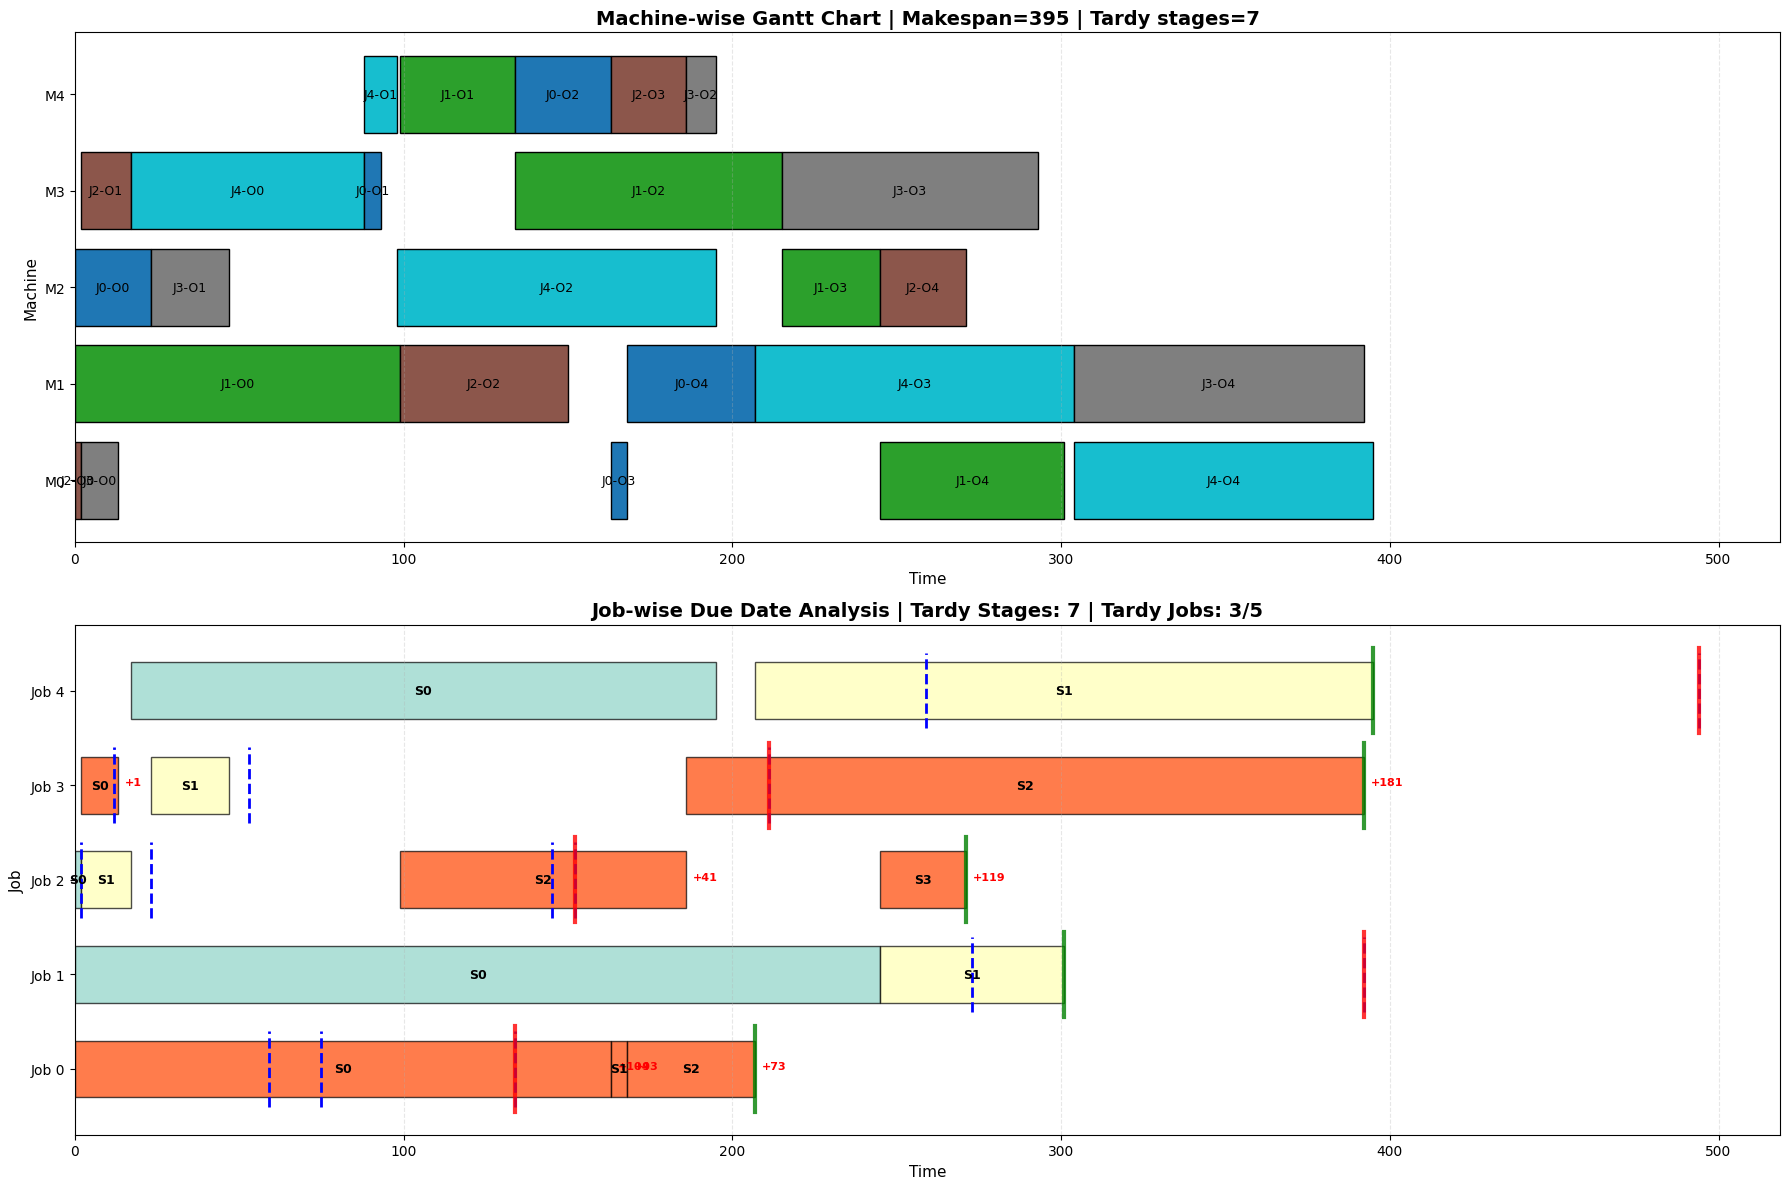

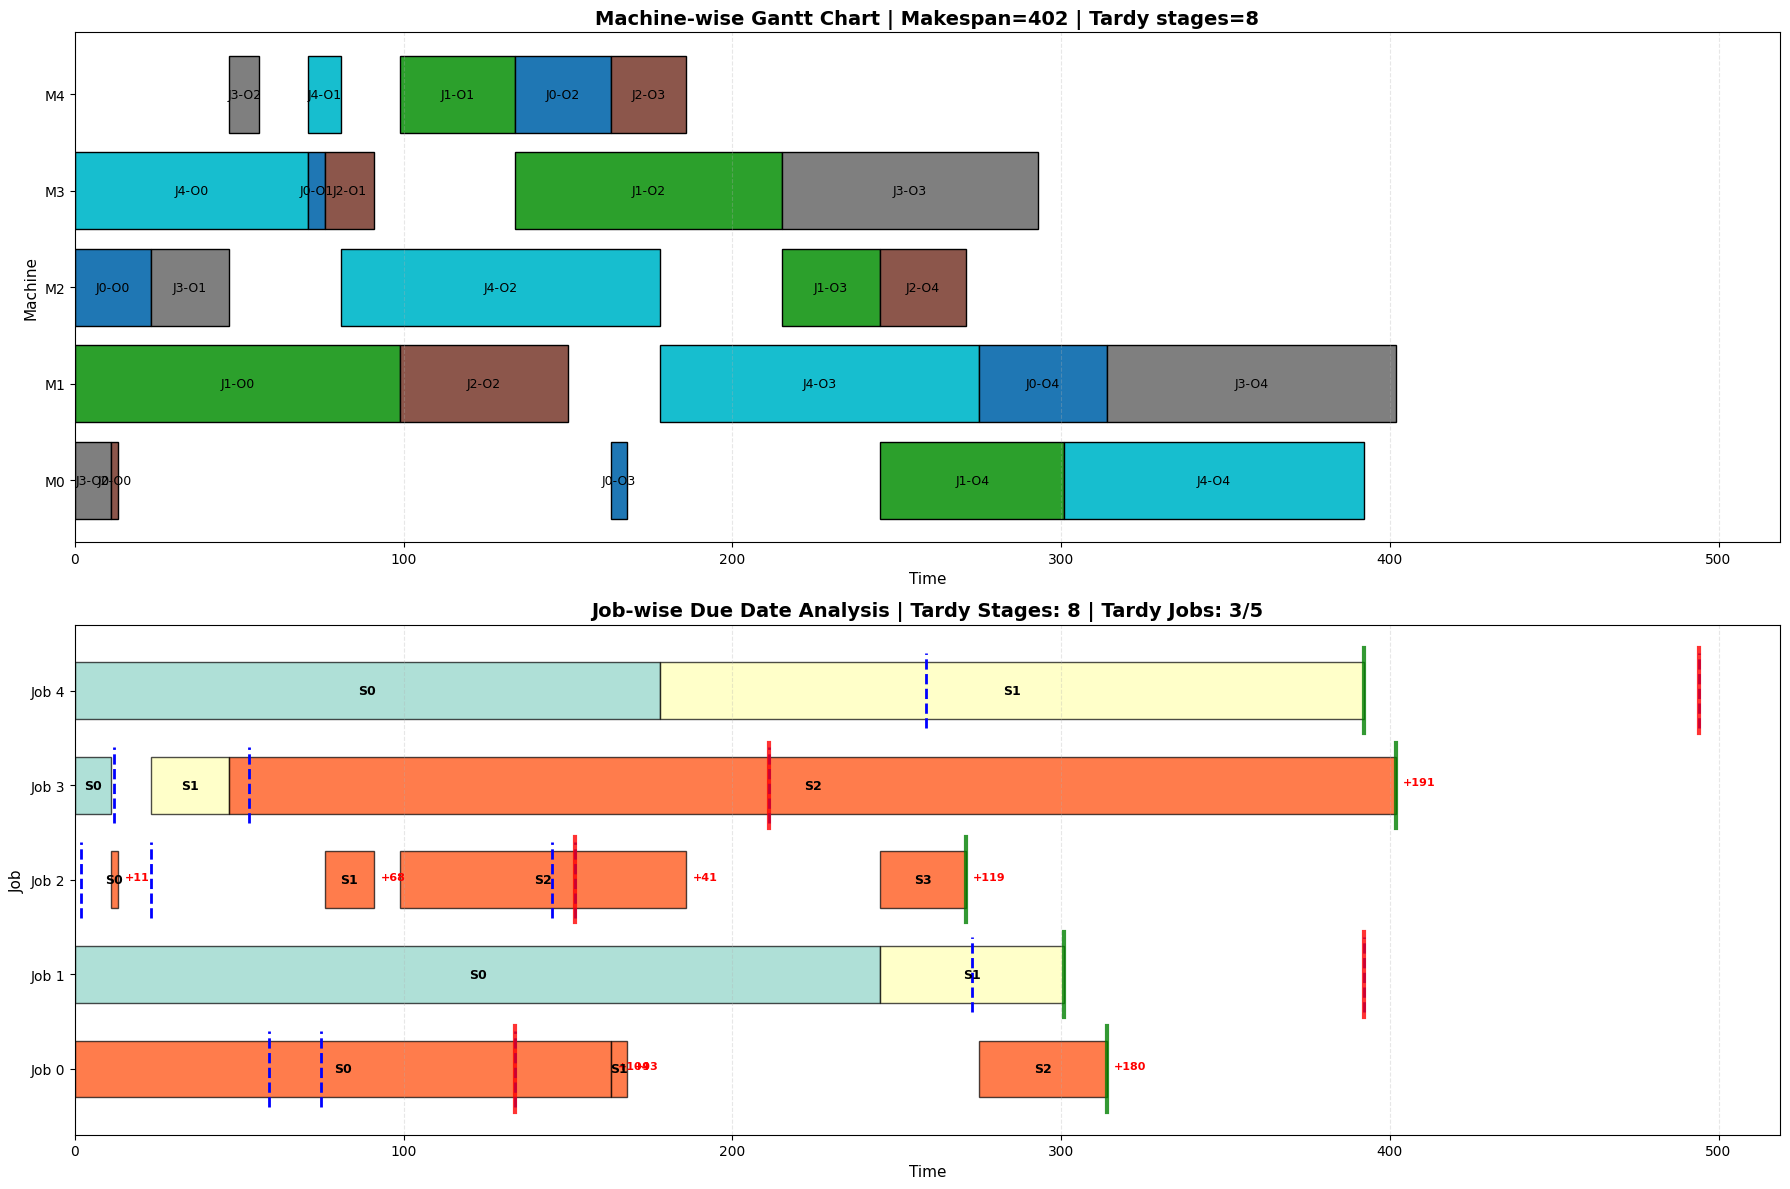

In [5]:
plot_both_views("train_data/5x5/nsga2_5x5_0800_traindata.jsp")
plot_both_views("output_solutions/5x5/nsga2_5x5_0800_traindata.jsp")

black_white

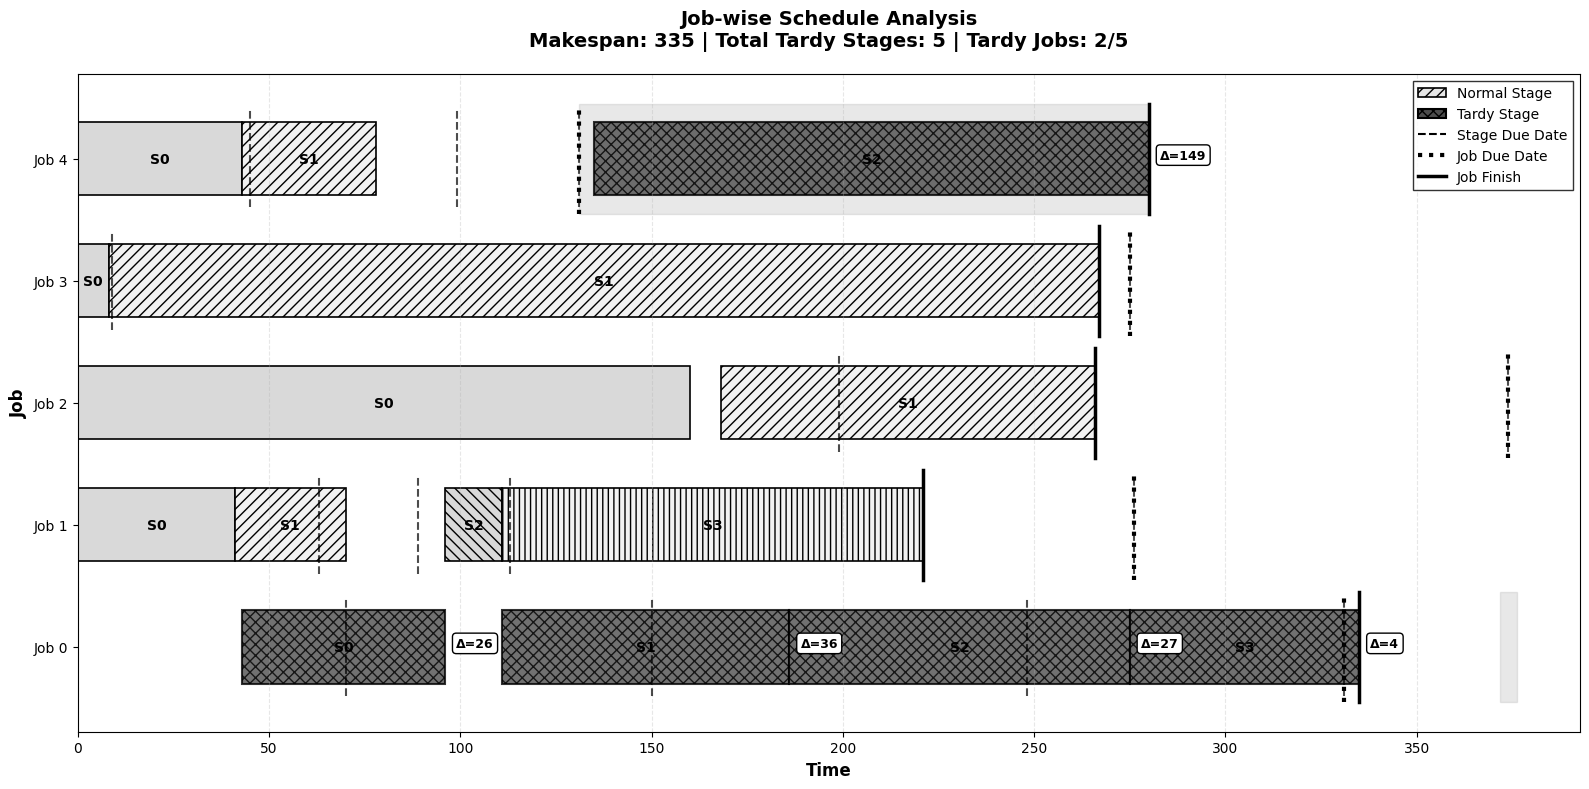

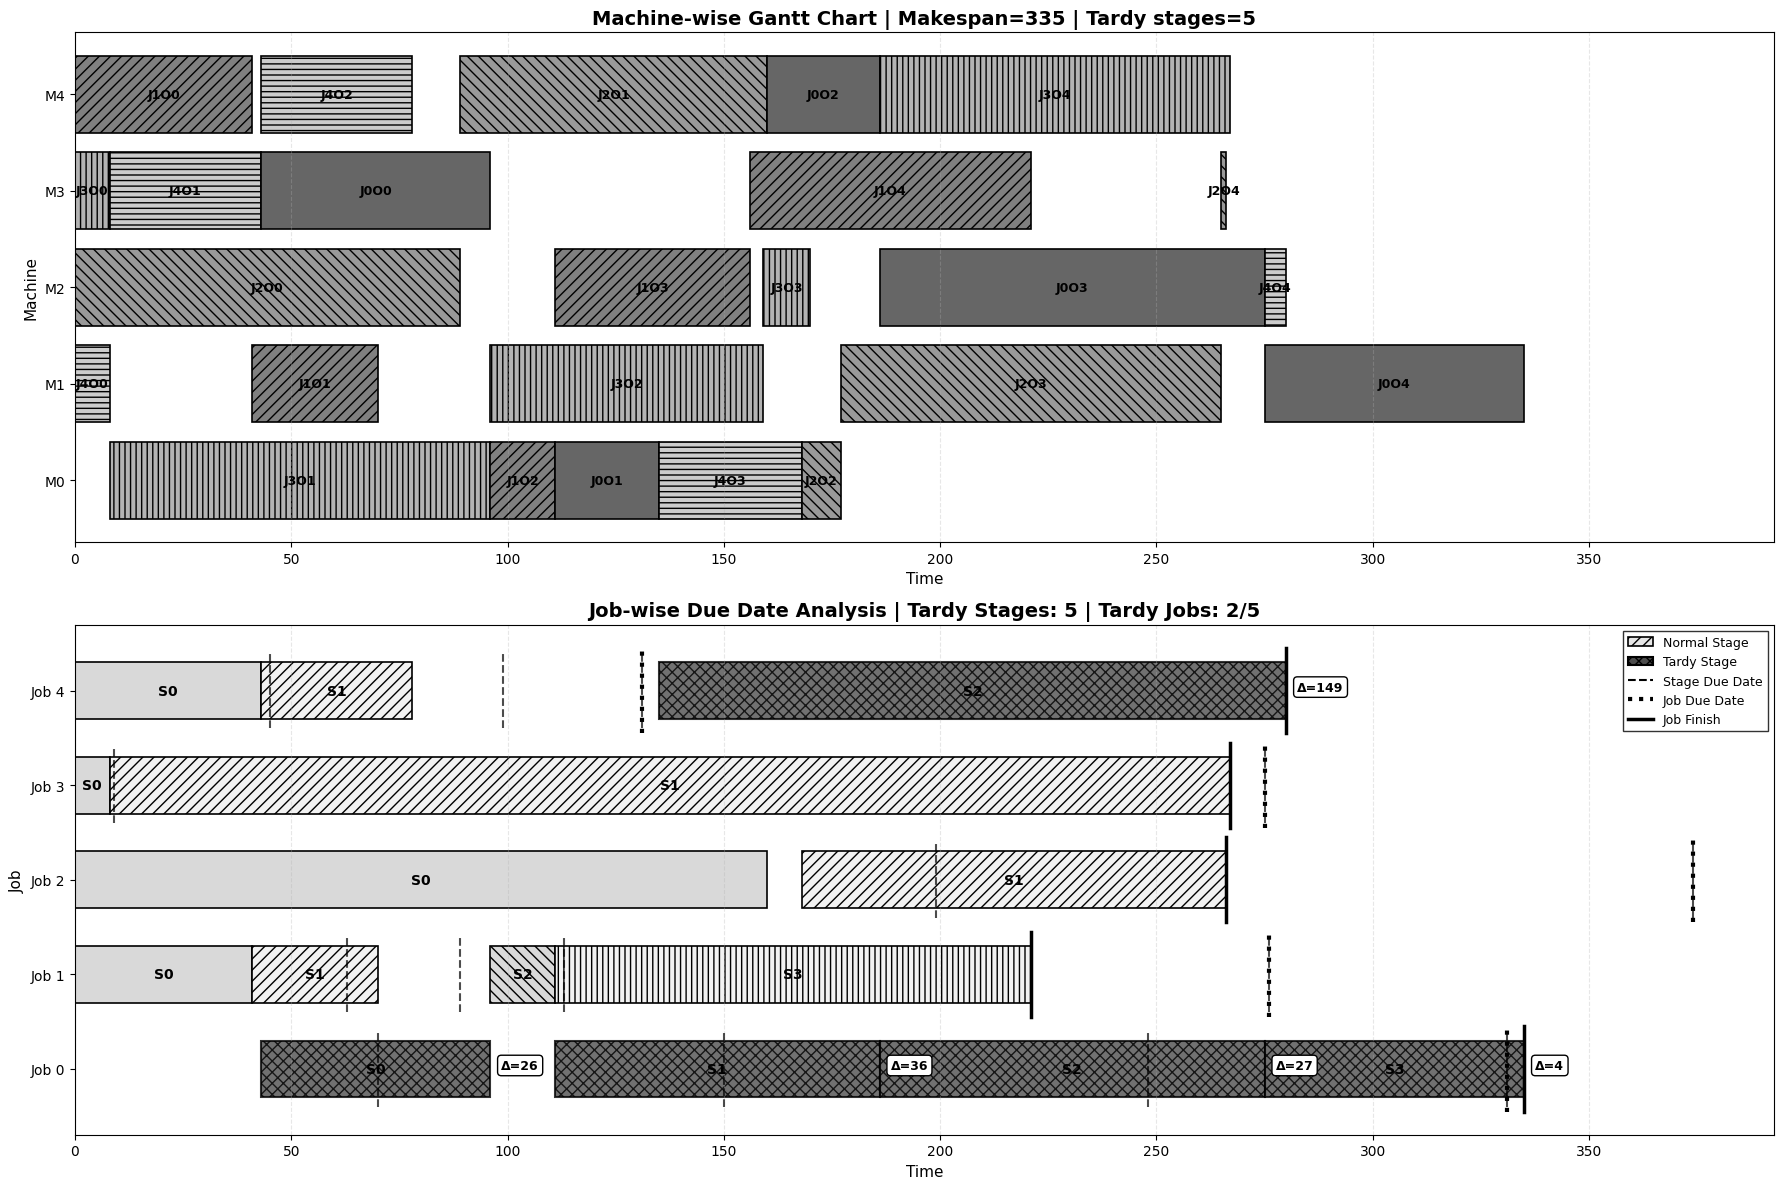

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 讀檔（支援你貼的格式）
# --------------------------------------------------
def read_instance(path):
    def next_non_empty(f):
        while True:
            line = f.readline()
            if not line:
                return None
            line = line.strip()
            if line:
                return line

    with open(path) as f:
        # jobs, machines
        line = next_non_empty(f)
        J, M = map(int, line.split())

        machines = np.zeros((J, M), dtype=int)
        costs = np.zeros((J, M), dtype=int)

        # operations
        for j in range(J):
            row = list(map(int, next_non_empty(f).split()))
            for o in range(M):
                machines[j, o] = row[2*o]
                costs[j, o] = row[2*o + 1]

        # -1
        assert next_non_empty(f) == "-1"

        stage_splits = []
        for _ in range(J):
            stage_splits.append(list(map(int, next_non_empty(f).split())))

        # -2
        assert next_non_empty(f) == "-2"

        stage_dd = []
        for _ in range(J):
            stage_dd.append(list(map(int, next_non_empty(f).split())))

        # makespan, tardy
        line = next_non_empty(f)
        makespan, tardy = map(int, line.split())

        # machine sequences
        machine_seq = []
        for _ in range(M):
            machine_seq.append(list(map(int, next_non_empty(f).split())))

    return J, M, machines, costs, stage_splits, stage_dd, machine_seq


# --------------------------------------------------
# 正確的 schedule builder
# --------------------------------------------------
def build_schedule(J, M, machines, costs, machine_seq):
    # gid → (job, op)
    gid_to_jo = {}
    for j in range(J):
        for o in range(M):
            gid_to_jo[j*M + o] = (j, o)

    # 追蹤每個 Job 的完工時間 (一維陣列即可)
    job_ready_time = [0] * J
    # 追蹤每台機器的完工時間
    mach_ready_time = [0] * M
    
    # 用來存放最終結果
    schedule = []
    # job_finish 矩陣用於計算 Tardy
    job_finish = [[0] * M for _ in range(J)]

    # 準備一個指針，紀錄每台機器目前處理到第幾個任務
    # 因為 machine_seq 是固定順序，我們只需按順序排入
    # 修正重點：建立一個待處理清單，只要該工序的前序好了，就嘗試排入
    queue = []
    for m in range(M):
        for gid in machine_seq[m]:
            j, o = gid_to_jo[gid]
            queue.append({'gid': gid, 'm': m, 'j': j, 'o': o})

    # 模擬排程
    # 這裡我們必須處理 Precedence (Job 內工序順序)
    # 我們重複檢查 queue，直到所有任務都排進去
    finished_count = 0
    ops_done = [[False] * M for _ in range(J)]
    processed_gid = set()

    while finished_count < J * M:
        progress = False
        for m in range(M):
            # 找到這台機器序列中下一個「尚未處理」的任務
            target_gid = None
            for gid in machine_seq[m]:
                if gid not in processed_gid:
                    target_gid = gid
                    break
            
            if target_gid is None:
                continue
                
            j, o = gid_to_jo[target_gid]
            
            # 檢查 Job 的前序工序是否完成
            if o > 0 and not ops_done[j][o-1]:
                continue # 前序沒好，這台機器現在只能等
            
            # 執行排程：開始時間 = max(機器空閒, Job前序完工)
            start = max(mach_ready_time[m], job_ready_time[j])
            duration = costs[j, o]
            end = start + duration
            
            # 更新狀態
            schedule.append((m, start, end, j, o))
            mach_ready_time[m] = end
            job_ready_time[j] = end
            job_finish[j][o] = end
            ops_done[j][o] = True
            processed_gid.add(target_gid)
            finished_count += 1
            progress = True
            
        if not progress:
            # 如果一輪下來都沒進度，代表 machine_seq 的順序與 Job 順序產生了 Deadlock (死結)
            # 這在 NSGA-II 的合法染色體下不應該發生
            raise RuntimeError("❌ 無法解碼：請檢查 machine_seq 是否違反了 Job 內部的工序順序。")

    return schedule, job_finish

# --------------------------------------------------
# Job視角的Due Date與Tardy視覺化
# --------------------------------------------------
def plot_job_due_dates(path):
    J, M, machines, costs, splits, dds, machine_seq = read_instance(path)
    schedule, job_finish = build_schedule(J, M, machines, costs, machine_seq)

    fig, ax = plt.subplots(figsize=(16, max(8, J * 0.8)))
    
    # 使用適合黑白印刷的填充樣式
    hatches = ['', '///', '\\\\\\', '|||', '---', '+++', 'xxx', '...', '**', 'oo', 'OO']
    
    total_tardy_stages = 0
    tardy_jobs = 0
    
    for j in range(J):
        # 計算每個stage的完成時間和tardy情況
        job_has_tardy = False
        
        for s in range(len(splits[j]) - 1):
            st_op, ed_op = splits[j][s], splits[j][s+1]
            
            if st_op == ed_op:
                continue
            
            # Stage的完成時間 = 該stage內所有operations的最大完成時間
            stage_finish = max(job_finish[j][st_op:ed_op])
            stage_due = dds[j][s]
            
            # 畫出stage的執行區間
            stage_start = min(
                start for m, start, end, jj, o in schedule 
                if jj == j and st_op <= o < ed_op
            )
            
            # 判斷是否tardy
            is_tardy = stage_finish > stage_due
            if is_tardy:
                total_tardy_stages += 1
                job_has_tardy = True
            
            # 畫stage執行時間條（黑白印刷友善）
            if is_tardy:
                # Tardy: 深灰色 + 密集斜線
                ax.barh(j, stage_finish - stage_start, left=stage_start, 
                       height=0.6, color='0.3', alpha=0.8, 
                       edgecolor='black', linewidth=1.5, hatch='xxx')
            else:
                # 正常: 白色/淺灰 + 不同填充樣式
                gray_level = 0.85 if s % 2 == 0 else 0.95
                ax.barh(j, stage_finish - stage_start, left=stage_start, 
                       height=0.6, color=str(gray_level), alpha=1.0, 
                       edgecolor='black', linewidth=1.2, 
                       hatch=hatches[s % len(hatches)])
            
            # 標示stage編號
            ax.text((stage_start + stage_finish) / 2, j, f'S{s}', 
                   ha='center', va='center', fontsize=10, fontweight='bold')
            
            # 畫stage due date線（黑色虛線，較細）
            ax.plot([stage_due, stage_due], [j - 0.4, j + 0.4], 
                   'k--', linewidth=1.5, alpha=0.7,
                   label='Stage DD' if j == 0 and s == 0 else '')
            
            # 如果tardy，用箭頭標示延遲量
            if is_tardy:
                delay = stage_finish - stage_due
                ax.annotate(f'Δ={delay}', xy=(stage_finish, j), 
                           xytext=(8, 0), textcoords='offset points',
                           fontsize=9, color='black', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', 
                                   facecolor='white', edgecolor='black', linewidth=1))
        
        if job_has_tardy:
            tardy_jobs += 1
        
        # 計算整個job的完成時間
        job_completion = max(job_finish[j])
        
        # 畫job完成時間的豎線（黑色實線，較粗）
        ax.plot([job_completion, job_completion], [j - 0.45, j + 0.45], 
               'k-', linewidth=2.5, alpha=1.0, 
               label='Job Finish' if j == 0 else '')
        
        # Job due date (取最後一個stage的due date)
        job_due = dds[j][-1] if dds[j] else 0
        if job_due > 0:
            # Job due date用點線表示
            ax.plot([job_due, job_due], [j - 0.45, j + 0.45], 
                   'k:', linewidth=3, alpha=1.0,
                   label='Job DD' if j == 0 else '')
            
            # 如果job tardy，用灰色背景標示
            if job_completion > job_due:
                ax.axhspan(j - 0.45, j + 0.45, 
                          xmin=job_due/plt.xlim()[1], 
                          xmax=job_completion/plt.xlim()[1], 
                          color='0.7', alpha=0.3, zorder=0)
    
    # 設定圖表屬性
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Job', fontsize=12, fontweight='bold')
    ax.set_yticks(range(J))
    ax.set_yticklabels([f'Job {j}' for j in range(J)])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # 標題包含統計資訊
    makespan = max(e for _, _, e, _, _ in schedule)
    ax.set_title(
        f'Job-wise Schedule Analysis\n'
        f'Makespan: {makespan} | Total Tardy Stages: {total_tardy_stages} | Tardy Jobs: {tardy_jobs}/{J}',
        fontsize=14, fontweight='bold', pad=20
    )
    
    # 圖例
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor='0.9', edgecolor='black', linewidth=1.2, hatch='///', label='Normal Stage'),
        Patch(facecolor='0.3', edgecolor='black', linewidth=1.5, hatch='xxx', label='Tardy Stage'),
        Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, label='Stage Due Date'),
        Line2D([0], [0], color='k', linestyle=':', linewidth=3, label='Job Due Date'),
        Line2D([0], [0], color='k', linestyle='-', linewidth=2.5, label='Job Finish'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             frameon=True, fancybox=False, edgecolor='black')
    
    plt.tight_layout()
    plt.show()


# --------------------------------------------------
# 主程式：畫兩張圖
# --------------------------------------------------
def plot_both_views(path):
    """同時畫Machine視角和Job視角的圖"""
    J, M, machines, costs, splits, dds, machine_seq = read_instance(path)
    schedule, job_finish = build_schedule(J, M, machines, costs, machine_seq)
    
    fig = plt.figure(figsize=(18, 12))
    
    # ============ 上半部：Machine Gantt Chart ============
    ax1 = plt.subplot(2, 1, 1)
    
    # 使用灰階和填充樣式區分不同Job
    hatches_job = ['', '///', '\\\\\\', '|||', '---', '+++', 'xxx', '...', '**', 'oo']
    
    for m, s, e, j, o in schedule:
        gray = 0.4 + (j / J) * 0.5  # 不同Job用不同灰階
        ax1.barh(m, e-s, left=s, color=str(gray), 
                edgecolor="black", linewidth=1.2,
                hatch=hatches_job[j % len(hatches_job)])
        ax1.text((s+e)/2, m, f"J{j}O{o}", ha="center", va="center", 
                fontsize=9, fontweight='bold')
    
    tardy = sum(
        1 for j in range(J) 
        for s in range(len(splits[j]) - 1)
        if splits[j][s] != splits[j][s+1] and 
        max(job_finish[j][splits[j][s]:splits[j][s+1]]) > dds[j][s]
    )
    makespan = max(e for _, _, e, _, _ in schedule)
    
    ax1.set_title(f"Machine-wise Gantt Chart | Makespan={makespan} | Tardy stages={tardy}", 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time", fontsize=11)
    ax1.set_ylabel("Machine", fontsize=11)
    ax1.set_yticks(range(M))
    ax1.set_yticklabels([f"M{m}" for m in range(M)])
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # ============ 下半部：Job Due Date View ============
    ax2 = plt.subplot(2, 1, 2)
    hatches_stage = ['', '///', '\\\\\\', '|||', '---', '+++', 'xxx', '...', '**', 'oo', 'OO']
    
    total_tardy_stages = 0
    tardy_jobs = 0
    
    for j in range(J):
        job_has_tardy = False
        
        for s in range(len(splits[j]) - 1):
            st_op, ed_op = splits[j][s], splits[j][s+1]
            if st_op == ed_op:
                continue
            
            stage_finish = max(job_finish[j][st_op:ed_op])
            stage_due = dds[j][s]
            stage_start = min(
                start for m, start, end, jj, o in schedule 
                if jj == j and st_op <= o < ed_op
            )
            
            is_tardy = stage_finish > stage_due
            if is_tardy:
                total_tardy_stages += 1
                job_has_tardy = True
            
            # 黑白印刷友善的設計
            if is_tardy:
                ax2.barh(j, stage_finish - stage_start, left=stage_start, 
                        height=0.6, color='0.3', alpha=0.8, 
                        edgecolor='black', linewidth=1.5, hatch='xxx')
            else:
                gray_level = 0.85 if s % 2 == 0 else 0.95
                ax2.barh(j, stage_finish - stage_start, left=stage_start, 
                        height=0.6, color=str(gray_level), alpha=1.0, 
                        edgecolor='black', linewidth=1.2, 
                        hatch=hatches_stage[s % len(hatches_stage)])
            
            ax2.text((stage_start + stage_finish) / 2, j, f'S{s}', 
                    ha='center', va='center', fontsize=10, fontweight='bold')
            
            # Stage due date（黑色虛線）
            ax2.plot([stage_due, stage_due], [j - 0.4, j + 0.4], 
                    'k--', linewidth=1.5, alpha=0.7)
            
            if is_tardy:
                delay = stage_finish - stage_due
                ax2.annotate(f'Δ={delay}', xy=(stage_finish, j), 
                            xytext=(8, 0), textcoords='offset points',
                            fontsize=9, color='black', fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', 
                                    facecolor='white', edgecolor='black', linewidth=1))
        
        if job_has_tardy:
            tardy_jobs += 1
        
        job_completion = max(job_finish[j])
        # Job完成時間（黑色實線）
        ax2.plot([job_completion, job_completion], [j - 0.45, j + 0.45], 
                'k-', linewidth=2.5, alpha=1.0)
        
        job_due = dds[j][-1] if dds[j] else 0
        if job_due > 0:
            # Job due date（黑色點線）
            ax2.plot([job_due, job_due], [j - 0.45, j + 0.45], 
                    'k:', linewidth=3, alpha=1.0)
    
    ax2.set_xlabel('Time', fontsize=11)
    ax2.set_ylabel('Job', fontsize=11)
    ax2.set_yticks(range(J))
    ax2.set_yticklabels([f'Job {j}' for j in range(J)])
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_title(
        f'Job-wise Due Date Analysis | Tardy Stages: {total_tardy_stages} | Tardy Jobs: {tardy_jobs}/{J}',
        fontsize=14, fontweight='bold'
    )
    
    # 添加圖例
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor='0.9', edgecolor='black', linewidth=1.2, hatch='///', label='Normal Stage'),
        Patch(facecolor='0.3', edgecolor='black', linewidth=1.5, hatch='xxx', label='Tardy Stage'),
        Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, label='Stage Due Date'),
        Line2D([0], [0], color='k', linestyle=':', linewidth=3, label='Job Due Date'),
        Line2D([0], [0], color='k', linestyle='-', linewidth=2.5, label='Job Finish'),
    ]
    ax2.legend(handles=legend_elements, loc='upper right', fontsize=9, 
              frameon=True, fancybox=False, edgecolor='black')
    
    plt.tight_layout()
    # 強制對齊兩個子圖的 X 軸（取兩者最大範圍）
    xlim1 = ax1.get_xlim()
    xlim2 = ax2.get_xlim()
    common_xlim = (min(xlim1[0], xlim2[0]), max(xlim1[1], xlim2[1]))
    ax1.set_xlim(common_xlim)
    ax2.set_xlim(common_xlim)
    plt.show()


# 使用方式：
# 1. 只畫Job視角
plot_job_due_dates("training_data/5x5/nsga2_5x5_0001_traindata.jsp")

# 2. 或同時畫兩張圖對比
plot_both_views("training_data/5x5/nsga2_5x5_0001_traindata.jsp")